# Problem Description

- A bank manager is in a scenario where several customers are leaving their credit card services. It would be extremely interesting for the company to be able to predict the customers most likely to leave such services so that, in this way, the bank can act preventively in order to offer better services in favor of maintaining the customer. The data set has 10,000 customers with attributes such as age, salary, marital status, credit limit, card category, among others. There are approximately 18 features in the whole set and there are only 16.0% of customers with churn.

- **CLIENTNUM:** unique identifier of the customer cartonista;
- **Attrition_Flag:** internal event related to customer activity;
- **Customer_Age:** age of the customer (in years);
- **Gender:** gender of the client (M = Male, F = Female);
- **Dependent_coun:** number of customer dependents;
- **Education_Level:** customer's school level;
- **Marital_Status:** marital status of the client;
- **Income_Category:** category related to the client's annual salary;
- **Card_Category:** credit card category (Blue, Silver, Gold or Platinum);
- **Months_on_book:** period of relationship with the bank (in months)
- **Total_Relationship_Count:** indicator of the customer's general relationship with the bank;
- **Months_Inactive_12_mon:** number of months of customer inactivity considering the last 12 months;
- **Contacts_Count_12_mon:** number of contacts registered by the customer considering the last 12 months;
- **Credit_Limit:** customer's credit limit;
- **Total_Revolving_Bal:** total revolving balance on the credit card;
- **Avg_Open_To_Buy:** indicator of purchase willingness by the customer (opening of offer);
- **Total_Amt_Chng_Q4_Q1:** probably indicates the value migrated between Q4 and Q1 for a full annual period;
- **Total_Trans_Amt:** total transaction amount (l|ast 12 months);
- **Total_Trans_Ct:** total transaction count (last 12 months);
- **Total_Ct_Chng_Q4_Q1:** probably indicates the amount migrated from card transactions between Q4 and Q1 for a full annual period;
- **Avg_Utilization_Ratio:** indicator of average customer usage of the card;
- **Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_Mon_Dependent_Count_Education_Level_Months_Inactive_12_Mon_1:**
- **Naive_Bayes_Classifier_Attrition_Flag_Card_Category_contacts_Count_12_Mon_Dependent_Count_Education_Level_Months_Inactive_12_Mon_2:**

## Problem Solution

- Build a model that determines potential customers to churn.

# Import

In [90]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import category_encoders as ce
import sweetviz as sv
import statsmodels.formula.api as smf
import pingouin as pg
from boruta import BorutaPy
import lightgbm as lgb
import shap

from sklearn.preprocessing   import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.datasets import make_classification
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, make_scorer

from IPython.core.display import display, HTML
import warnings

# Def Function

In [3]:
def side_by_side_tables(model1, model2):
    # Getting the summaries as HTML
    resume_model1_html = model1.summary().as_html()
    resume_model2_html = model2.summary().as_html()

    # Creating an HTML div that contains the tables side by side
    side_by_side_tables_html = f'<div style="display:flex;">' \
                               f'<div style="margin-right:20px;">{resume_model1_html}</div>' \
                               f'<div>{resume_model2_html}</div>' \
                               f'</div>'

    # Displaying tables side by side
    display(HTML(side_by_side_tables_html))

def rename_columns(df):
    # Convert column names to lowercase
    df.columns = [col.lower() for col in df.columns]

    # Rename specific columns
    df = df.rename(columns={
        'naive_bayes_classifier_attrition_flag_card_category_contacts_count_12_mon_dependent_count_education_level_months_inactive_12_mon_1':
        'naive_bayes_classifier_1',
        'naive_bayes_classifier_attrition_flag_card_category_contacts_count_12_mon_dependent_count_education_level_months_inactive_12_mon_2':
        'naive_bayes_classifier_2'
    })

    return df

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [12, 6]
    plt.rcParams['font.size'] = 16
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [4]:
jupyter_settings();

Populating the interactive namespace from numpy and matplotlib


In [5]:
sns.set(style='whitegrid')

In [6]:
warnings.filterwarnings("ignore")

# Data Preprocessing

In [7]:
df = pd.read_csv('Data/BankChurners.csv')
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [8]:
df.shape

(10127, 23)

In [9]:
df.dtypes

CLIENTNUM                                                                                                                               int64
Attrition_Flag                                                                                                                         object
Customer_Age                                                                                                                            int64
Gender                                                                                                                                 object
Dependent_count                                                                                                                         int64
Education_Level                                                                                                                        object
Marital_Status                                                                                                                         object
Income

In [10]:
df.isna().sum()

CLIENTNUM                                                                                                                             0
Attrition_Flag                                                                                                                        0
Customer_Age                                                                                                                          0
Gender                                                                                                                                0
Dependent_count                                                                                                                       0
Education_Level                                                                                                                       0
Marital_Status                                                                                                                        0
Income_Category                                 

In [11]:
df = rename_columns(df)

In [12]:
existing_customer = re.compile('Existing Customer')	
attrited_customer = re.compile('Attrited Customer')

df['attrition_flag'] = df['attrition_flag'].apply(lambda x: existing_customer.sub('1', x))
df['attrition_flag'] = df['attrition_flag'].apply(lambda x: attrited_customer.sub('0', x))

df['attrition_flag'] = pd.to_numeric(df['attrition_flag'], errors='coerce')

In [13]:
df.head()

,clientnum,attrition_flag,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio,naive_bayes_classifier_1,naive_bayes_classifier_2
0,768805383,1,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,1,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,1,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,1,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,1,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [14]:
df.dtypes

clientnum                     int64
attrition_flag                int64
customer_age                  int64
gender                       object
dependent_count               int64
education_level              object
marital_status               object
income_category              object
card_category                object
months_on_book                int64
total_relationship_count      int64
months_inactive_12_mon        int64
contacts_count_12_mon         int64
credit_limit                float64
total_revolving_bal           int64
avg_open_to_buy             float64
total_amt_chng_q4_q1        float64
total_trans_amt               int64
total_trans_ct                int64
total_ct_chng_q4_q1         float64
avg_utilization_ratio       float64
naive_bayes_classifier_1    float64
naive_bayes_classifier_2    float64
dtype: object

## Categorial variables analysis

In [15]:
df.gender.value_counts()

F    5358
M    4769
Name: gender, dtype: int64

In [16]:
df.card_category.value_counts()

Blue        9436
Silver       555
Gold         116
Platinum      20
Name: card_category, dtype: int64

In [17]:
df.education_level.value_counts()

Graduate         3128
High School      2013
Unknown          1519
Uneducated       1487
College          1013
Post-Graduate     516
Doctorate         451
Name: education_level, dtype: int64

In [18]:
df.marital_status.value_counts()

Married     4687
Single      3943
Unknown      749
Divorced     748
Name: marital_status, dtype: int64

In [19]:
df.income_category.value_counts()

Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
Unknown           1112
$120K +            727
Name: income_category, dtype: int64

# Feature Engineering

In [20]:
df1 = df.copy()

In [21]:
df1 = df1.drop(['naive_bayes_classifier_1', 'naive_bayes_classifier_2'], axis=1)

In [22]:
df1.head()

,clientnum,attrition_flag,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio
0,768805383,1,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,1,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,1,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,1,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,1,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [23]:
df1.shape

(10127, 21)

In [24]:
df1.dtypes

clientnum                     int64
attrition_flag                int64
customer_age                  int64
gender                       object
dependent_count               int64
education_level              object
marital_status               object
income_category              object
card_category                object
months_on_book                int64
total_relationship_count      int64
months_inactive_12_mon        int64
contacts_count_12_mon         int64
credit_limit                float64
total_revolving_bal           int64
avg_open_to_buy             float64
total_amt_chng_q4_q1        float64
total_trans_amt               int64
total_trans_ct                int64
total_ct_chng_q4_q1         float64
avg_utilization_ratio       float64
dtype: object

## Create new features

In [25]:
# Transaction Frequency: Create a feature that represents the average frequency of transactions per month.
df1['avg_trans_freq'] = df1['total_trans_ct'] / df1['months_on_book']

# Customer Relationship Intensity: Create a feature that takes into account the total number of relationships and transactions.
df1['relationship_intensity'] = df1['total_relationship_count'] * df1['total_trans_ct']

# Card Change Frequency: Create a feature that indicates how often the customer changes the type of credit card.
df1['card_change_freq'] = df1['total_ct_chng_q4_q1'] / df1['months_on_book']

# Contact Intensity: Create a feature that takes into account contact intensity weighted by the number of dependents.
df1['contact_intensity'] = (df1['contacts_count_12_mon'] + df1['months_inactive_12_mon']) / (df1['dependent_count'] + 1)

In [26]:
df1.head()

,clientnum,attrition_flag,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio,avg_trans_freq,relationship_intensity,card_change_freq,contact_intensity
0,768805383,1,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,1.076923,210,0.041667,1.00
1,818770008,1,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.750000,198,0.084409,0.50
2,713982108,1,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.555556,80,0.064806,0.25
3,769911858,1,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.588235,60,0.068618,1.00
4,709106358,1,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,1.333333,140,0.119048,0.25


In [27]:
df1.shape

(10127, 25)

In [28]:
df1.dtypes

clientnum                     int64
attrition_flag                int64
customer_age                  int64
gender                       object
dependent_count               int64
education_level              object
marital_status               object
income_category              object
card_category                object
months_on_book                int64
total_relationship_count      int64
months_inactive_12_mon        int64
contacts_count_12_mon         int64
credit_limit                float64
total_revolving_bal           int64
avg_open_to_buy             float64
total_amt_chng_q4_q1        float64
total_trans_amt               int64
total_trans_ct                int64
total_ct_chng_q4_q1         float64
avg_utilization_ratio       float64
avg_trans_freq              float64
relationship_intensity        int64
card_change_freq            float64
contact_intensity           float64
dtype: object

## Encoding

In [29]:
ordinal_encoder_income_category = {'Less than $40K': 1, '$40K - $60K': 2, '$60K - $80K': 3, '$80K - $120K': 4, '$120K +': 5, 'Unknown': -1}
df1['income_category'] = df1['income_category'].map(ordinal_encoder_income_category)

ordinal_encoder_education_level = {'Unknown': -1, 'Uneducated': 1, 'High School': 2, 'College': 3, 'Graduate': 4, 'Post-Graduate': 5, 'Doctorate': 6}
df1['education_level'] = df1['education_level'].map(ordinal_encoder_education_level)

ordinal_encoder_card_category = {'Blue': 1, 'Silver': 2, 'Gold': 3, 'Platinum': 4}
df1['card_category'] = df1['card_category'].map(ordinal_encoder_card_category)

oe_gender = ce.OrdinalEncoder(cols=['gender'], mapping=[{'col': 'gender', 'mapping': {'M': 0, 'F': 1}}])
df1 = oe_gender.fit_transform(df1)

ohe_marital_status = ce.OneHotEncoder(cols=['marital_status'], use_cat_names=True)
df1 = ohe_marital_status.fit_transform(df1)

In [30]:
df1.head()

,clientnum,attrition_flag,customer_age,gender,dependent_count,education_level,marital_status_Married,marital_status_Single,marital_status_Unknown,marital_status_Divorced,income_category,card_category,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio,avg_trans_freq,relationship_intensity,card_change_freq,contact_intensity
0,768805383,1,45,0,3,2,1,0,0,0,3,1,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,1.076923,210,0.041667,1.00
1,818770008,1,49,1,5,4,0,1,0,0,1,1,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.750000,198,0.084409,0.50
2,713982108,1,51,0,3,4,1,0,0,0,4,1,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.555556,80,0.064806,0.25
3,769911858,1,40,1,4,2,0,0,1,0,1,1,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.588235,60,0.068618,1.00
4,709106358,1,40,0,3,1,1,0,0,0,3,1,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,1.333333,140,0.119048,0.25


## Features transformation

In [31]:
df2 = df1.copy()

In [32]:
rs = RobustScaler()
mms = MinMaxScaler()
ss = StandardScaler()

# robust scaler
df2['months_inactive_12_mon'] = rs.fit_transform(df2[['months_inactive_12_mon']].values)
df2['contacts_count_12_mon'] = rs.fit_transform(df2[['contacts_count_12_mon']].values)
df2['total_amt_chng_q4_q1'] = rs.fit_transform(df2[['total_amt_chng_q4_q1']].values)
df2['total_trans_ct'] = rs.fit_transform(df2[['total_trans_ct']].values)
df2['total_ct_chng_q4_q1'] = rs.fit_transform(df2[['total_ct_chng_q4_q1']].values)
df2['credit_limit'] = rs.fit_transform(df2[['credit_limit']].values)
df2['months_on_book'] = rs.fit_transform(df2[['months_on_book']].values)

# min max scaler
df2['total_trans_amt'] = mms.fit_transform(df2[['total_trans_amt']].values)

# standard scaler
df2['customer_age'] = ss.fit_transform(df2[['customer_age']].values)

# EDA

In [33]:
#sv.analyze(df).show_html()

In [34]:
df.describe()

,clientnum,attrition_flag,customer_age,dependent_count,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio,naive_bayes_classifier_1,naive_bayes_classifier_2
count,1.012700e+04,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,7.391776e+08,0.839340,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894,0.159997,0.840003
std,3.690378e+07,0.367235,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691,0.365301,0.365301
min,7.080821e+08,0.000000,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000,0.000008,0.000420
25%,7.130368e+08,1.000000,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000,0.000099,0.999660
50%,7.179264e+08,1.000000,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000,0.000181,0.999820
75%,7.731435e+08,1.000000,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000,0.000337,0.999900
max,8.283431e+08,1.000000,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000,0.999580,0.999990


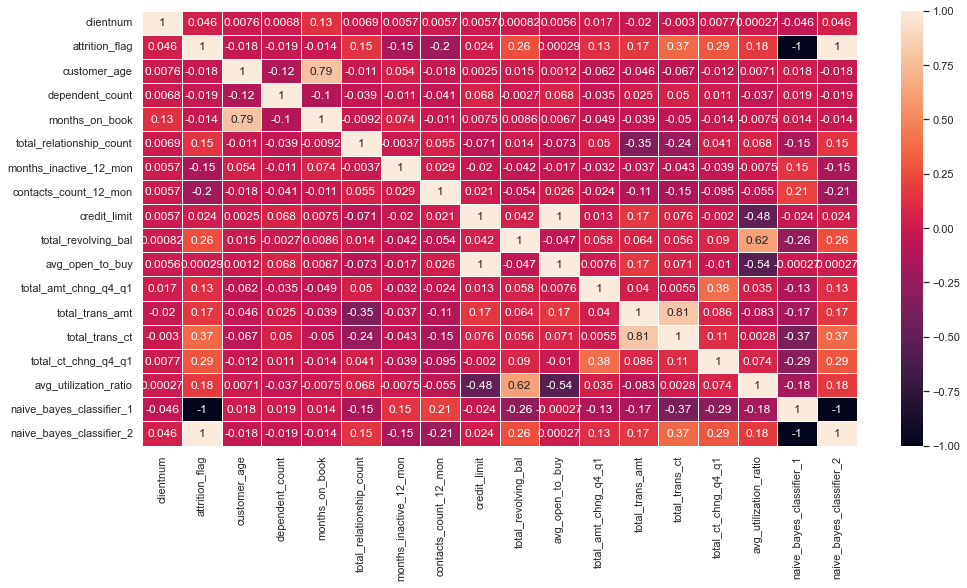

In [35]:
plt.figure(figsize=(16,8))
sns.heatmap(df.corr(method='pearson'), annot=True, linewidths=.5);

In [36]:
pg.ttest(df.total_trans_amt, df.total_trans_ct)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,128.537663,20252,two-sided,0.0,"[4273.06, 4405.4]",1.806363,inf,1.0


In [37]:
pg.ttest(df.months_on_book, df.customer_age)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-92.465139,20252,two-sided,0.0,"[-10.62, -10.18]",1.299429,inf,1.0


- By analyzing the heat map, we noticed that the features **naive_bayes_classifier_1** and **naive_bayes_classifier_2** have a high inverse correlation, in addition, **avg_open_to_buy** and **credit_limit** also have a high level of correlation. We also analyzed the relationship between the features **total_trans_amt** and **total_trans_ct** which present a statistically significant difference by the T test as well as **months_on_book** and **customer_age**. Thus, the **naive_bayes_classifier_1**, **naive_bayes_classifier_2** and **avg_open_to_buy** columns will be removed for model training.

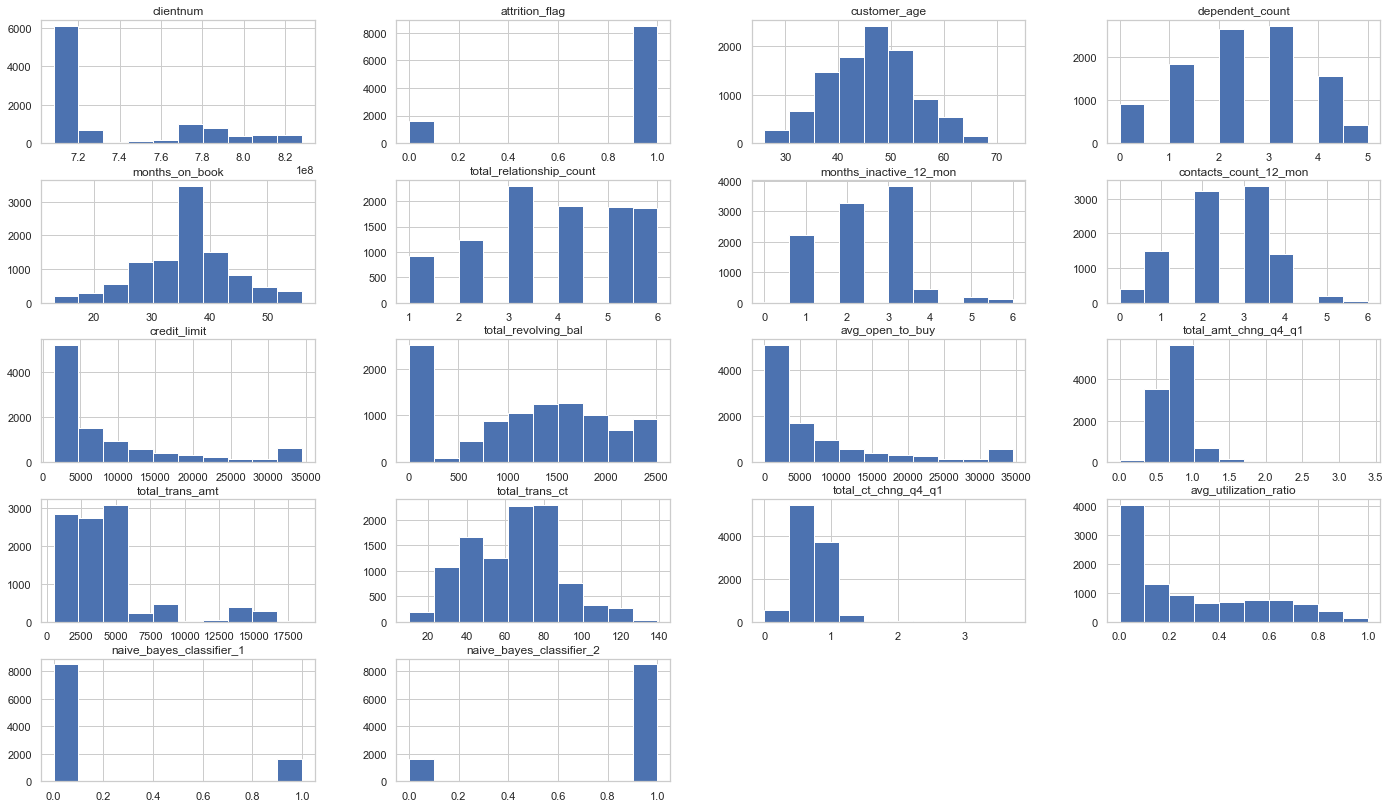

In [38]:
features = df.columns.tolist()
df[features].hist(figsize=(24, 14));

In [39]:
aux1 = df.groupby(['income_category','attrition_flag']).agg({'credit_limit' : 'mean'})
aux1.reset_index(inplace=True)
aux1

,income_category,attrition_flag,credit_limit
0,$120K +,0,19734.380952
1,$120K +,1,19713.746256
2,$40K - $60K,0,5049.799262
3,$40K - $60K,1,5535.845622
4,$60K - $80K,0,10491.971958
5,$60K - $80K,1,10800.343776
6,$80K - $120K,0,15296.733058
7,$80K - $120K,1,15905.934416
8,Less than $40K,0,3483.306536
9,Less than $40K,1,3810.664937


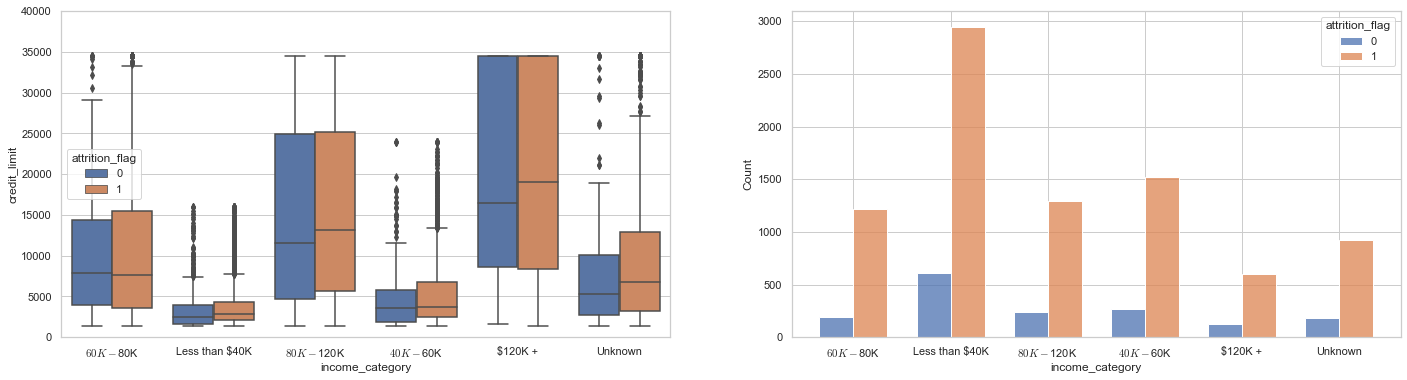

In [40]:
plt.figure(figsize=(24,6))

plt.subplot(1, 2, 1)
sns.boxplot(x='income_category',y='credit_limit', data=df, hue=df.attrition_flag)
plt.ylim(0,40000)

plt.subplot(1, 2, 2)
sns.histplot(x='income_category', hue='attrition_flag', data=df, multiple='dodge', shrink=0.7);

plt.show()

In [41]:
aux2 = df.groupby('customer_age').agg({'credit_limit' : 'mean'})
aux2.reset_index(inplace=True)
aux2.head(10)

,customer_age,credit_limit
0,26,4591.953846
1,27,5532.996875
2,28,8910.103448
3,29,7457.260714
4,30,6466.075714
5,31,8477.200000
6,32,8170.900943
7,33,7455.800000
8,34,7364.219863
9,35,7132.426630


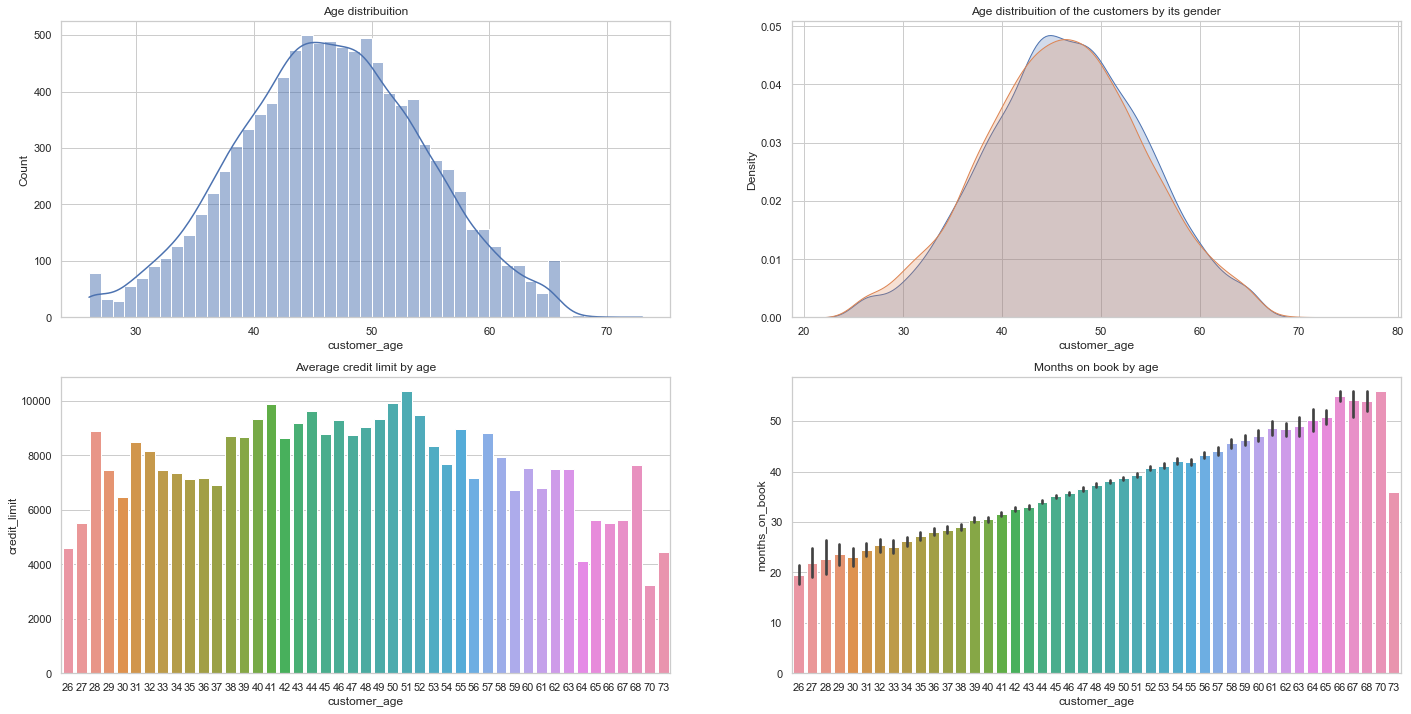

In [42]:
plt.figure(figsize=(24,12))

plt.subplot(2, 2, 1)
sns.histplot(df.customer_age, kde=True)
plt.title('Age distribuition')

plt.subplot(2, 2, 2)
sns.kdeplot(df[df['gender'] == 'F']['customer_age'], label='F', shade=True)
sns.kdeplot(df[df['gender'] == 'M']['customer_age'], label='M', shade=True)
plt.title('Age distribuition of the customers by its gender')

plt.subplot(2, 2, 3)
sns.barplot(x='customer_age', y='credit_limit', data=aux2)
plt.title('Average credit limit by age')

plt.subplot(2, 2, 4)
sns.barplot(x='customer_age', y='months_on_book', data=df)
plt.title('Months on book by age')

plt.show()

In [43]:
model1 = smf.ols(formula='credit_limit ~ customer_age', data=aux2).fit()
model2 = smf.ols(formula='credit_limit ~ customer_age + I(customer_age**2)', data=aux2).fit()

side_by_side_tables(model1, model2)

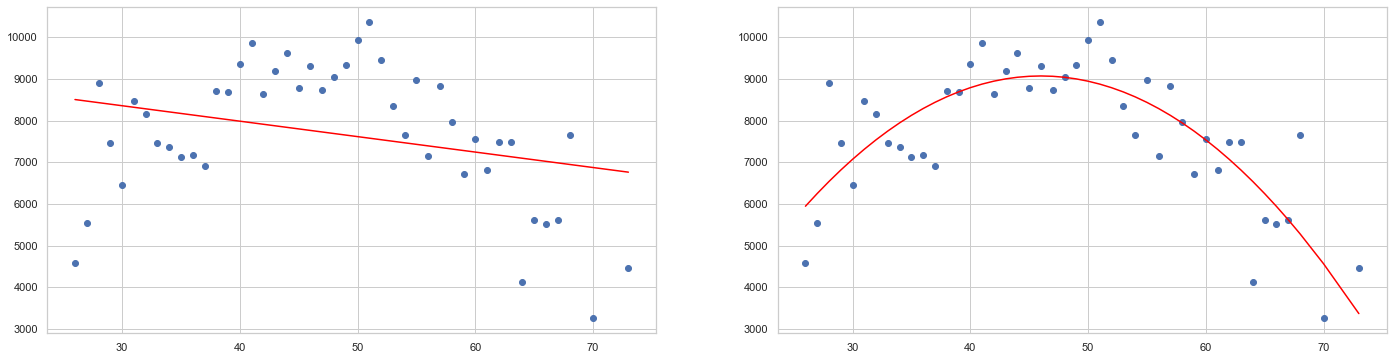

In [44]:
yhat1 = model1.predict(aux2.customer_age)
yhat2 = model2.predict(aux2.customer_age)
plt.figure(figsize=(24,6))

plt.subplot(1, 2, 1)
plt.scatter(x='customer_age', y='credit_limit', data=aux2)
plt.plot(aux2.customer_age, yhat1, c='red')

plt.subplot(1, 2, 2)
plt.scatter(x='customer_age', y='credit_limit', data=aux2)
plt.plot(aux2.customer_age, yhat2, c='red');

In [45]:
pg.ttest(
    df.loc[df.gender == 'M', 'customer_age'],
    df.loc[df.gender == 'F', 'customer_age']
)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.740356,9944.619099,two-sided,0.081827,"[-0.59, 0.04]",0.034684,0.102,0.413849


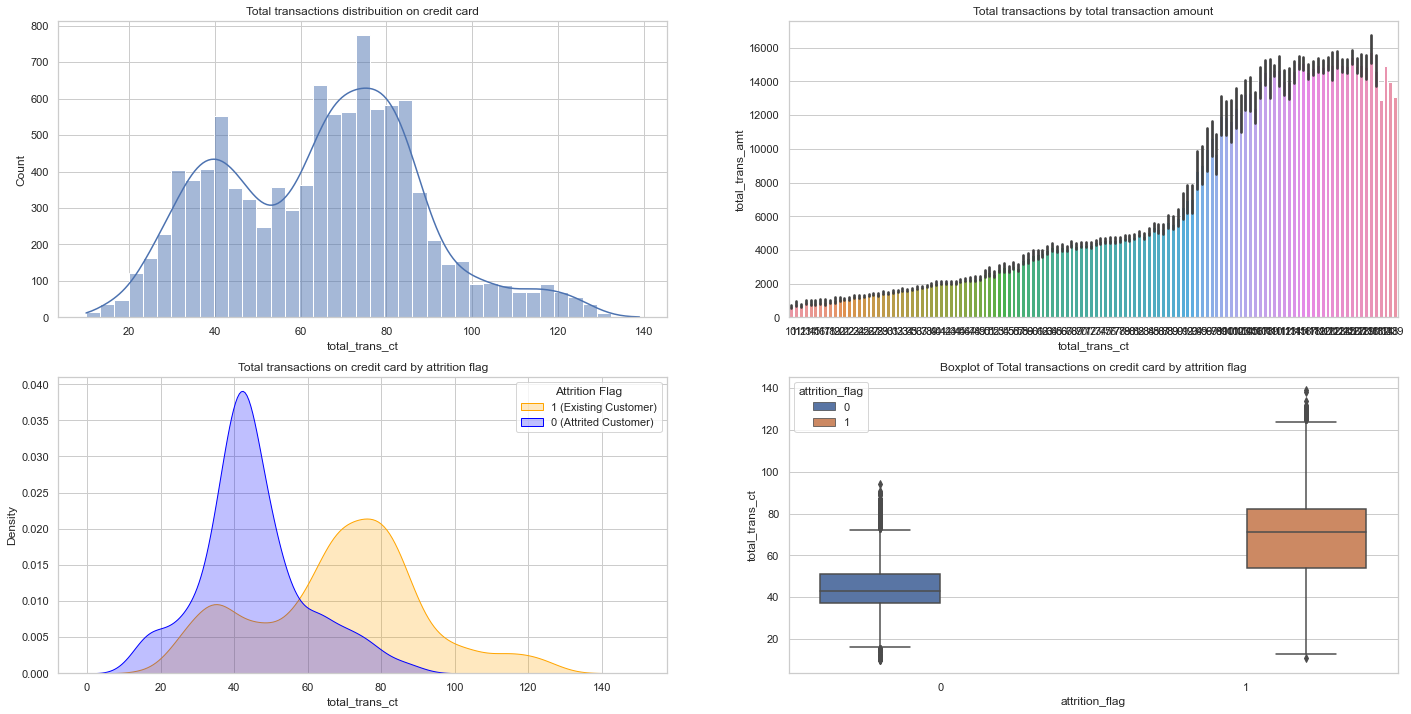

In [46]:
plt.figure(figsize=(24, 12))

plt.subplot(2, 2, 1)
sns.histplot(df.total_trans_ct, kde=True)
plt.title('Total transactions distribuition on credit card')

plt.subplot(2, 2, 2)
sns.barplot(x='total_trans_ct', y='total_trans_amt', data=df)
plt.title('Total transactions by total transaction amount')

plt.subplot(2, 2, 3)
sns.kdeplot(df[df['attrition_flag'] == 1]['total_trans_ct'], label=1, color='orange', shade=True)
sns.kdeplot(df[df['attrition_flag'] == 0]['total_trans_ct'], label=0, color='blue', shade=True)
plt.title('Total transactions on credit card by attrition flag')
plt.legend(title='Attrition Flag', labels=['1 (Existing Customer)', '0 (Attrited Customer)'])

plt.subplot(2, 2, 4)
sns.boxplot(x='attrition_flag',y='total_trans_ct', data=df, hue=df.attrition_flag)
plt.title('Boxplot of Total transactions on credit card by attrition flag');

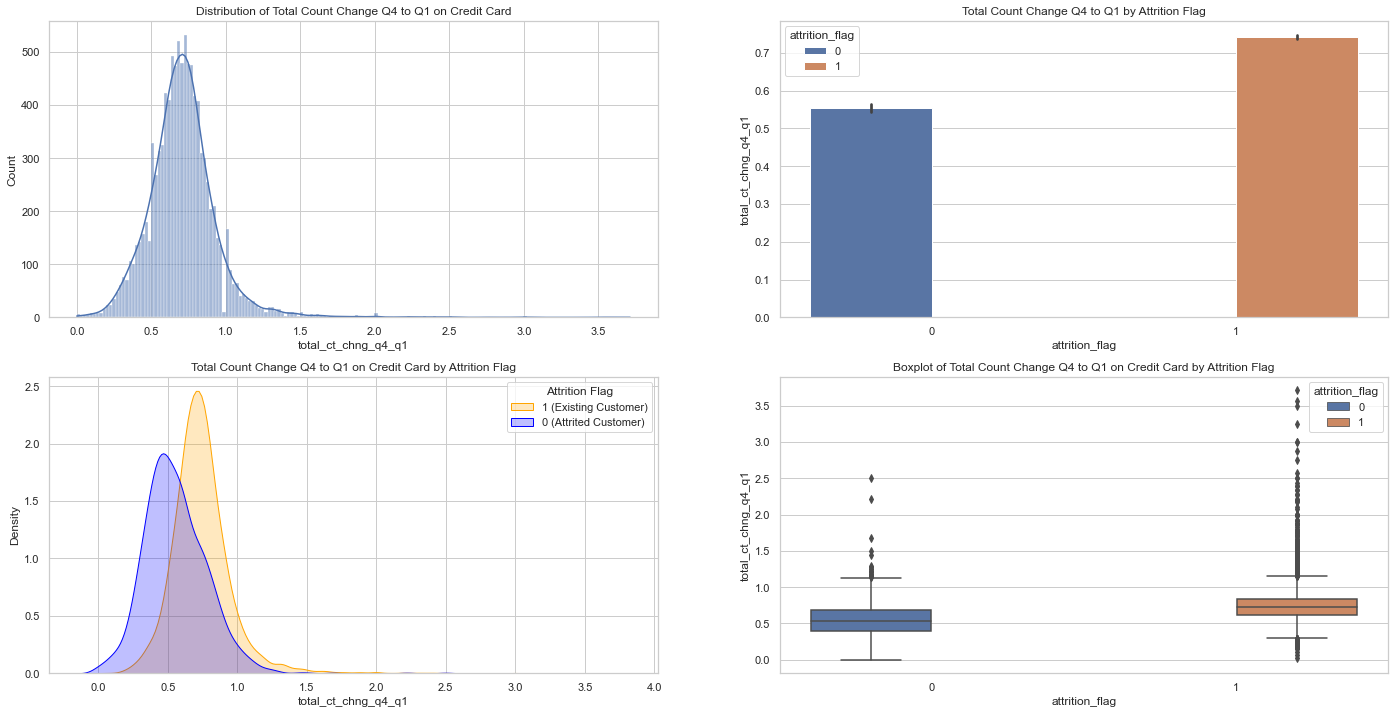

In [47]:
plt.figure(figsize=(24,12))

plt.subplot(2, 2, 1)
sns.histplot(df.total_ct_chng_q4_q1, kde=True)
plt.title('Distribution of Total Count Change Q4 to Q1 on Credit Card')

plt.subplot(2, 2, 2)
sns.barplot(x='attrition_flag',y='total_ct_chng_q4_q1', data=df, hue=df.attrition_flag)
plt.title('Total Count Change Q4 to Q1 by Attrition Flag')

plt.subplot(2, 2, 3)
sns.kdeplot(df[df['attrition_flag'] == 1]['total_ct_chng_q4_q1'], label=1, color='orange', shade=True)
sns.kdeplot(df[df['attrition_flag'] == 0]['total_ct_chng_q4_q1'], label=0, color='blue', shade=True)
plt.title('Total Count Change Q4 to Q1 on Credit Card by Attrition Flag')
plt.legend(title='Attrition Flag', labels=['1 (Existing Customer)', '0 (Attrited Customer)'])

plt.subplot(2, 2, 4)
sns.boxplot(x='attrition_flag',y='total_ct_chng_q4_q1', data=df, hue=df.attrition_flag)
plt.title('Boxplot of Total Count Change Q4 to Q1 on Credit Card by Attrition Flag');

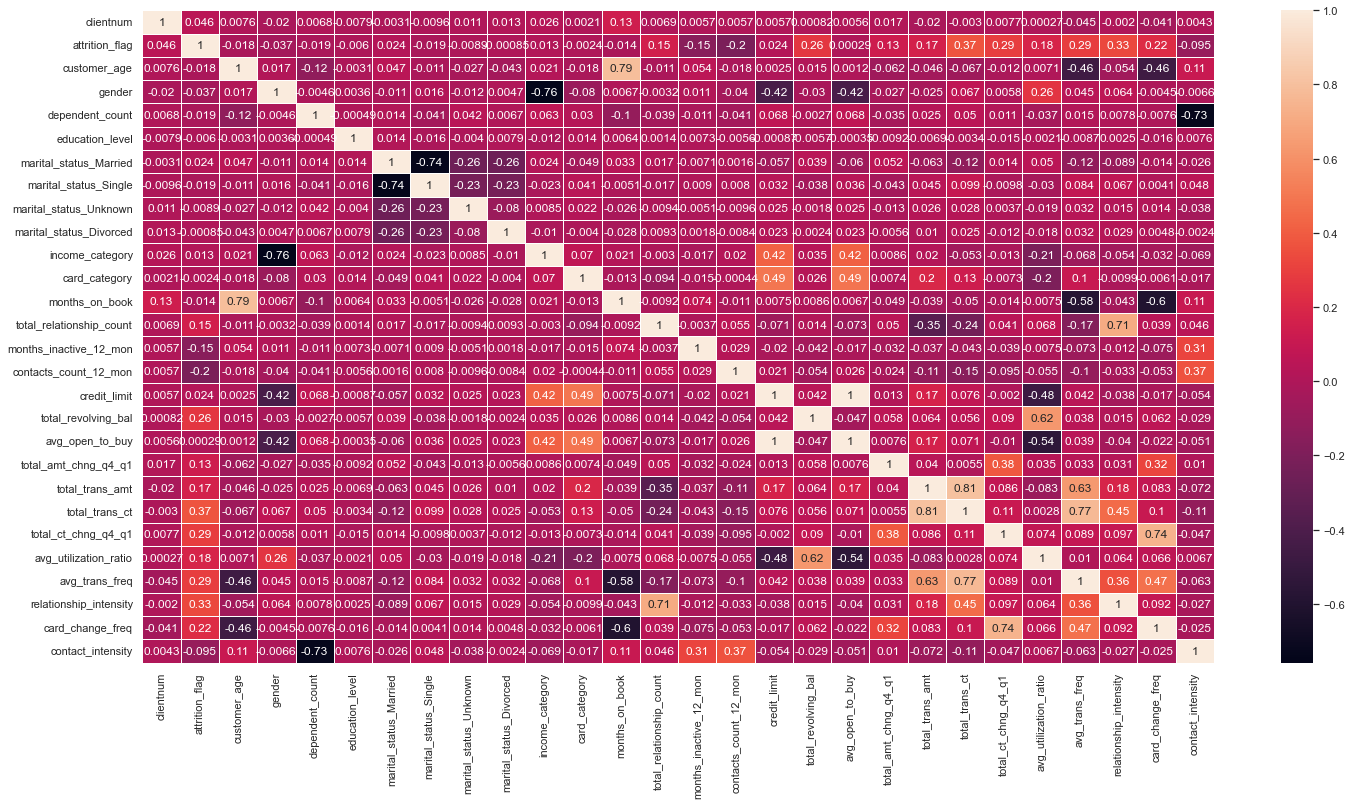

In [48]:
plt.figure(figsize=(24,12))
sns.heatmap(df1.corr(method='pearson'), annot=True, linewidths=.5);

# Model

## Split data

In [147]:
df3 = df2.copy()

df3 = df3.drop(['clientnum', 'avg_open_to_buy'], axis=1)
df4 = df3.drop(['attrition_flag'], axis=1)

- the feature **avg_open_to_buy** was removed because it had a high correlation with the feature **credit_limit**

In [148]:
# X are the features and y is the target variable (churn or not churn)
X = df4
y = df3['attrition_flag']

# Dividing the data into training and testing (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Feature Selection

In [149]:
# training and test dataset for boruta
#x_train_n = X_train
#y_train_n = y_train.ravel()

# define RandomForestClassifier
#rf = RandomForestClassifier()

# define boruta
#boruta = BorutaPy(rf, n_estimators=1024, max_iter=100, verbose=2, random_state=42).fit(x_train_n, y_train_n)

In [150]:
#cols_selected = boruta.support_.tolist()
#selected_indices = [i for i, value in enumerate(cols_selected) if value]
#cols_selected_boruta = df4.columns[selected_indices].tolist()

#print("Selected column names:", cols_selected_boruta)

In [151]:
# best columns selected by boruta
best_cols_boruta = ['customer_age', 'months_on_book',
                    'total_relationship_count', 'months_inactive_12_mon',
                    'contacts_count_12_mon', 'credit_limit',
                    'total_revolving_bal', 'total_amt_chng_q4_q1',
                    'total_trans_amt', 'total_trans_ct',
                    'total_ct_chng_q4_q1', 'avg_utilization_ratio',
                    'avg_trans_freq', 'relationship_intensity',
                    'card_change_freq', 'contact_intensity']

## Machine Learning Modeling

In [152]:
# X are the features and y is the target variable (churn or not churn)
X = df4[best_cols_boruta]
y = df3['attrition_flag']

# Dividing the data into training and testing (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Logistic Regression

In [153]:
# model
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

# prediction
y_pred_lr = lr.predict(X_test)

accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy: {accuracy_lr}")

f1_score_lr = f1_score(y_test, y_pred_lr, average='macro')
print(f"f1score: {f1_score_lr}")

precision_lr = precision_score(y_test, y_pred_lr, average='macro')
print(f"Precicion: {precision_lr}")

recall_lr = recall_score(y_test, y_pred_lr, average='macro')
print(f"Recall: {recall_lr}")

Accuracy: 0.8923988153998026
f1score: 0.7648966364528704
Precicion: 0.8320355599560767
Recall: 0.7280857414190747


In [154]:
# scoring metrics
scoring_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'f1_macro': make_scorer(f1_score, average='macro'),
    'precision_macro': make_scorer(precision_score, average='macro'),
    'recall_macro': make_scorer(recall_score, average='macro')
}

# cross validation
cv_results = cross_validate(lr, X_train, y_train, cv=5, scoring=scoring_metrics)

print(f"Cross-Validation Results:")
print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
print(f"F1 Score (Macro): {cv_results['test_f1_macro'].mean()}")
print(f"Precision (Macro): {cv_results['test_precision_macro'].mean()}")
print(f"Recall (Macro): {cv_results['test_recall_macro'].mean()}")

Cross-Validation Results:
Accuracy: 0.8956923405000723
F1 Score (Macro): 0.7749972301194346
Precision (Macro): 0.8367465404339164
Recall (Macro): 0.7397949310095685


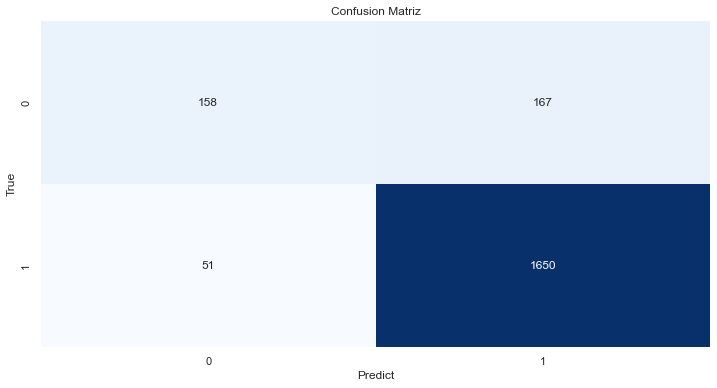

In [155]:
# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lr)

# Plot confusion matriz
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matriz")
plt.xlabel("Predict")
plt.ylabel("True")
plt.show()

### Random Forest Classifier

In [156]:
# model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# prediction
y_pred_rf = rf.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy_rf}")

f1_score_rf = f1_score(y_test, y_pred_rf, average='macro')
print(f"f1score: {f1_score_rf}")

precision_rf = precision_score(y_test, y_pred_rf, average='macro')
print(f"Precision: {precision_rf}")

recall_rf = recall_score(y_test, y_pred_rf, average='macro')
print(f"Recall: {recall_rf}")

Accuracy: 0.9619940769990128
f1score: 0.9275442891465988
Precision: 0.93971972614463
Recall: 0.9163849319404875


In [157]:
scoring_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'f1_macro': make_scorer(f1_score, average='macro'),
    'precision_macro': make_scorer(precision_score, average='macro'),
    'recall_macro': make_scorer(recall_score, average='macro')
}

cv_results = cross_validate(rf, X_train, y_train, cv=5, scoring=scoring_metrics)

print(f"Cross-Validation Results:")
print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
print(f"F1 Score (Macro): {cv_results['test_f1_macro'].mean()}")
print(f"Precision (Macro): {cv_results['test_precision_macro'].mean()}")
print(f"Recall (Macro): {cv_results['test_recall_macro'].mean()}")

Cross-Validation Results:
Accuracy: 0.9592637527513119
F1 Score (Macro): 0.9213276499807634
Precision (Macro): 0.940466193875243
Recall (Macro): 0.904623567035916


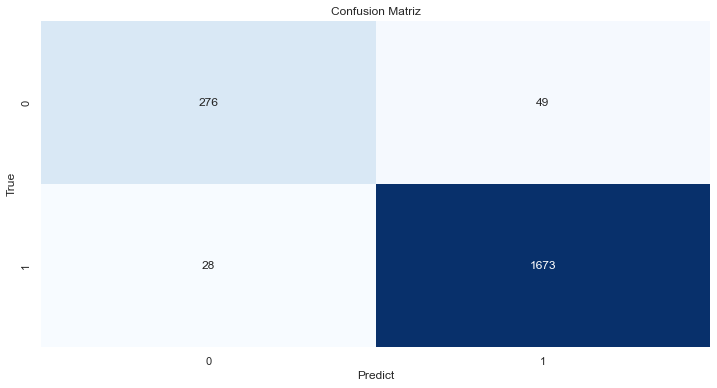

In [58]:
# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)

# Plot confusion matriz
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matriz")
plt.xlabel("Predict")
plt.ylabel("True")
plt.show()

In [191]:
explainer = shap.Explainer(rf)
shap_values = explainer(X)

np.shape(shap_values.values)

In [198]:
shap.plots.force(shap_values[0][:, 1])

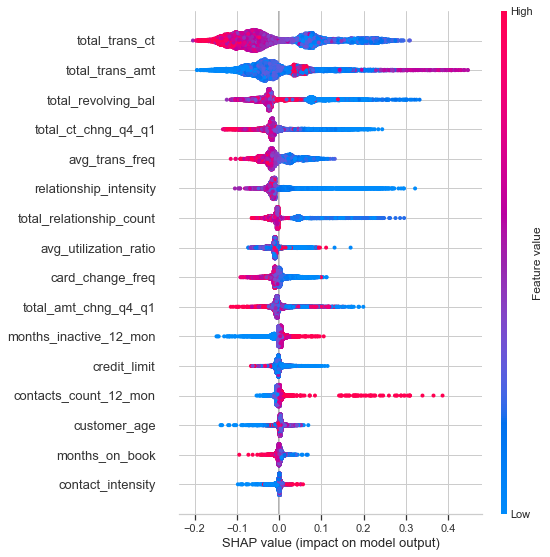

In [196]:
shap.summary_plot(shap_values[:, :, 0], X)

### Gradient Boosting Classifier

In [78]:
# model
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)

# prediction
y_pred_gb = gb.predict(X_test)

accuracy_gb = accuracy_score(y_test, y_pred_gb)
print(f"Accuracy: {accuracy_gb}")

f1_score_gb = f1_score(y_test, y_pred_gb, average='macro')
print(f"f1score: {f1_score_gb}")

precision_gb = precision_score(y_test, y_pred_gb, average='macro')
print(f"Precision: {precision_gb}")

recall_gb = recall_score(y_test, y_pred_gb, average='macro')
print(f"Recall: {recall_gb}")

Accuracy: 0.9624876604146101
f1score: 0.9274455143972421
Precision: 0.9468774186687253
Recall: 0.9104562926785149


In [86]:
scoring_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'f1_macro': make_scorer(f1_score, average='macro'),
    'precision_macro': make_scorer(precision_score, average='macro'),
    'recall_macro': make_scorer(recall_score, average='macro')
}

cv_results = cross_validate(gb, X_train, y_train, cv=5, scoring=scoring_metrics)

print(f"Cross-Validation Results:")
print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
print(f"F1 Score (Macro): {cv_results['test_f1_macro'].mean()}")
print(f"Precision (Macro): {cv_results['test_precision_macro'].mean()}")
print(f"Recall (Macro): {cv_results['test_recall_macro'].mean()}")

Cross-Validation Results:
Accuracy: 0.9634610551328627
F1 Score (Macro): 0.9289160625657992
Precision (Macro): 0.9523171071314998
Recall (Macro): 0.9089965184169474


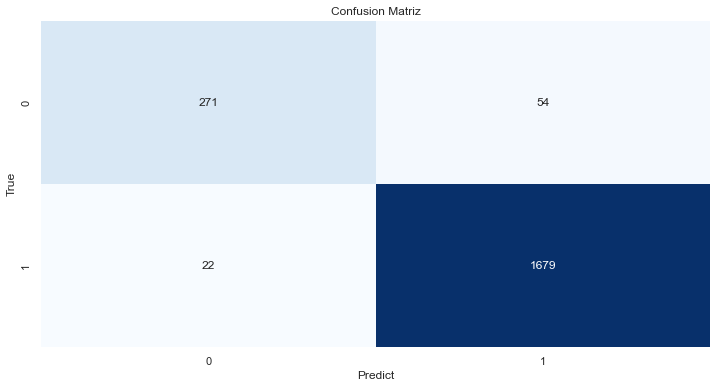

In [60]:
# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred_gb)

# Plot confusion matriz
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matriz")
plt.xlabel("Predict")
plt.ylabel("True")
plt.show()

In [200]:
explainer = shap.Explainer(gb)
shap_values = explainer(X)

np.shape(shap_values.values)

(10127, 16)

In [203]:
shap.plots.force(shap_values[0])

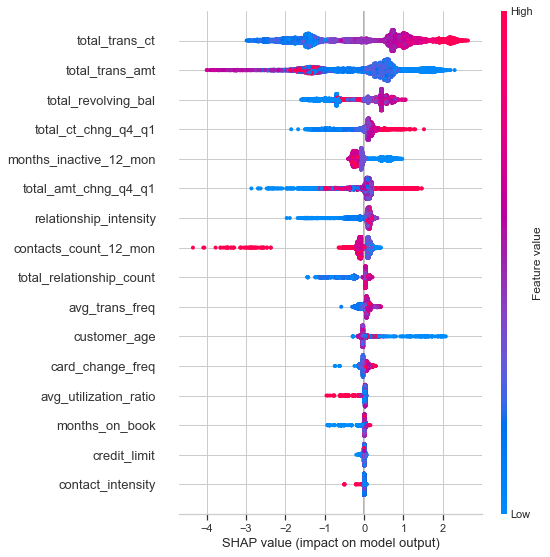

In [201]:
shap.summary_plot(shap_values, X)

### LGBM Classifier

In [79]:
# model
lgbm = lgb.LGBMClassifier(random_state=42)
lgbm.fit(X_train, y_train)

# prediction
y_pred_lgbm = lgbm.predict(X_test)

accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
print(f"Accuracy: {accuracy_lgbm}")

f1_score_lgbm = f1_score(y_test, y_pred_lgbm, average='macro')
print(f"f1score: {f1_score_lgbm}")

precision_lgbm = precision_score(y_test, y_pred_lgbm, average='macro')
print(f"Precision: {precision_lgbm}")

recall_lgbm = recall_score(y_test, y_pred_lgbm, average='macro')
print(f"Recall: {recall_lgbm}")

Accuracy: 0.9708785784797631
f1score: 0.9456049219231724
Precision: 0.9484338364595546
Recall: 0.9428327228327228


In [87]:
scoring_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'f1_macro': make_scorer(f1_score, average='macro'),
    'precision_macro': make_scorer(precision_score, average='macro'),
    'recall_macro': make_scorer(recall_score, average='macro')
}

cv_results = cross_validate(lgbm, X_train, y_train, cv=5, scoring=scoring_metrics)

print(f"Cross-Validation Results:")
print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
print(f"F1 Score (Macro): {cv_results['test_f1_macro'].mean()}")
print(f"Precision (Macro): {cv_results['test_precision_macro'].mean()}")
print(f"Recall (Macro): {cv_results['test_recall_macro'].mean()}")

Cross-Validation Results:
Accuracy: 0.971114766833459
F1 Score (Macro): 0.9451976363441073
Precision (Macro): 0.955983658365575
Recall (Macro): 0.9352900445198076


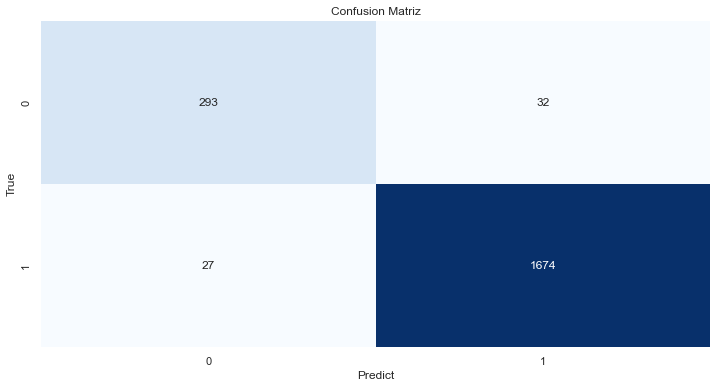

In [62]:
# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lgbm)

# Plot confusion matriz
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matriz")
plt.xlabel("Predict")
plt.ylabel("True")
plt.show()

In [204]:
explainer = shap.Explainer(lgbm)
shap_values = explainer(X)

np.shape(shap_values.values)

(10127, 16, 2)

In [206]:
shap.plots.force(shap_values[0][:, 1])

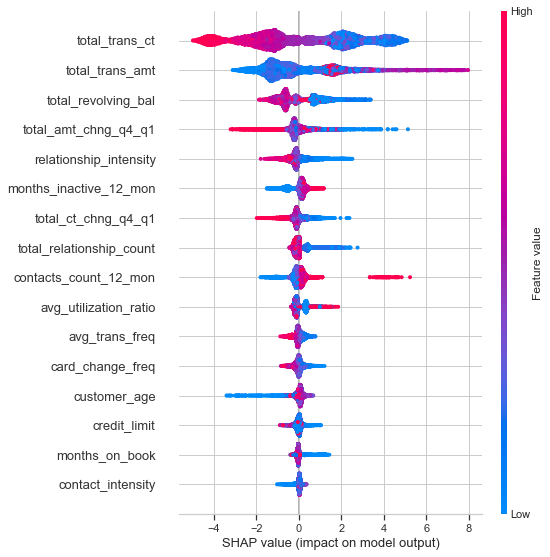

In [207]:
shap.summary_plot(shap_values[:, :, 0], X)

## Compare Models

## Hyperparameter Tuning

# Metrics Comprehension